4.918573481102094
39.99208037017417
0.49 1.9600000000000002 9.96
15.887168871688717
Results saved to submission_train2.csv


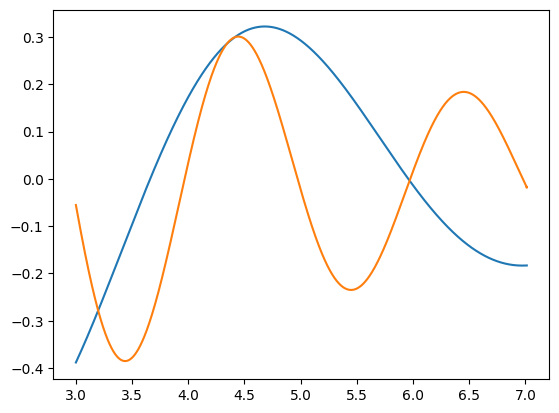

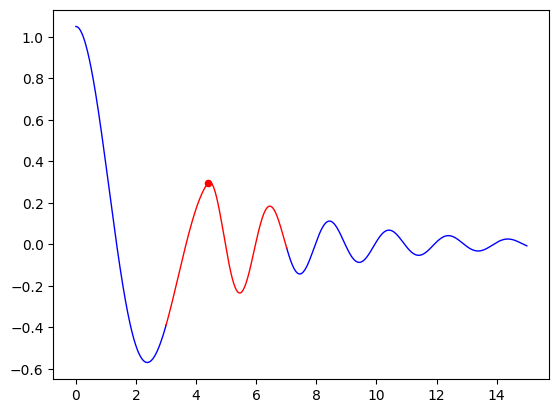

{'l': 5, 'miu': 0.49, 'F': 40, 't_nextzerotheta': 15.88, 't_Fput': 4.4}


In [ ]:
import numpy as np
import torch
from torch import nn
from scipy.integrate import odeint
import pandas as pd
import matplotlib.pyplot as plt
import math
import os
import zipfile
from math import ceil

def derivative(t, theta):
    dthetadt = (theta[1:] - theta[:-1]) / (t[1:] - t[:-1])
    return dthetadt

def load_data(csv_path):
    ttheta = pd.read_csv(csv_path)
    t = np.array(ttheta["t"])
    theta = np.array(ttheta["theta"])
    return t, theta

def split_data(t, theta, threshold=1):
    theta_1 = []
    t_1 = []
    theta_2 = []
    t_2 = []
    force_flag = False
    
    t_1.append(t[0])
    theta_1.append(theta[0])
    for i in range(1, len(t)):
        if t[i] - t[i-1] < threshold:
            if not force_flag:
                t_1.append(t[i])
                theta_1.append(theta[i])
            else:
                t_2.append(t[i])
                theta_2.append(theta[i])
        else:
            force_flag = True
            t_2.append(t[i])
            theta_2.append(theta[i])
    
    return np.array(t_1), np.array(theta_1), np.array(t_2), np.array(theta_2)

def theta_func(thetaomega, t, alpha, beta):
    theta, omega = thetaomega
    a = -alpha * omega - beta * math.sin(theta)
    return np.array([omega, a])

class SinglePendulum(nn.Module):
    def __init__(self, beta1=None, beta2=None):
        super().__init__()
        self.alpha = nn.Parameter(torch.randn((1,), requires_grad=True))
        if beta1:
            self.beta_1 = beta1
        else:
            self.beta_1 = nn.Parameter(torch.randn((1,), requires_grad=True))
        if beta2:
            self.beta_2 = beta2
        else:
            self.beta_2 = nn.Parameter(torch.randn((1,), requires_grad=True))
    def forward(self, theta, omega, add_force=False):
        if not add_force:
            a = -self.alpha * omega - self.beta_1 * torch.sin(theta)
        else:
            a = -self.alpha * omega - self.beta_2 * torch.sin(theta)
        return a.squeeze()

def get_next_zerotheta_timestamp(t, theta):
    for i in range(1, len(theta)):
        if theta[i-1] * theta[i] < 0:
            return t[i]


def get_break_timestamp(break_t, theta_1_forward, theta_2_backward): #Find the moment when F disappears by identifying the intersection point of the curves.
    min_val = math.inf 
    min_idx = 0 
    for i in range(len(break_t) - 1): 
        val = abs(theta_1_forward[i] - theta_2_backward[i]) 
        dtheta_1 = theta_1_forward[i + 1] - theta_1_forward[i] 
        dtheta_2 = theta_2_backward[i + 1] - theta_2_backward[i] 
        val += abs((dtheta_1 - dtheta_2) / (break_t[i + 1] - break_t[i])) 
        if val < min_val: 
            min_val = val
            min_idx = i
        # if min_val < 0.001:
        #     break
    
    theta = theta_1_forward[:min_idx].tolist() + theta_2_backward[min_idx:].tolist()
    return break_t[min_idx], np.array(theta)


def optimize(model, t1, theta1, t2, theta2, epoch_num=1000, lr=0.1):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    omega1 = derivative(t1, theta1)
    a_true = derivative(t1[1:], omega1)

    omega2 = derivative(t2, theta2)
    a_true2 = derivative(t2[1:], omega2)
    
    theta1_tensor = torch.from_numpy(theta1[1:-1]).float()
    omega1_tensor = torch.from_numpy(omega1[:-1]).float()
    a_true_tensor = torch.from_numpy(a_true).float()
    
    theta2_tensor = torch.from_numpy(theta2[1:-1]).float()
    omega2_tensor = torch.from_numpy(omega2[:-1]).float()
    a_true_tensor2 = torch.from_numpy(a_true2).float()
    
    for epoch in range(epoch_num):
        optimizer.zero_grad()
        a_pred = model(theta1_tensor, omega1_tensor)
        a_pred2 = model(theta2_tensor, omega2_tensor, add_force=True)
        loss = (torch.mean((a_pred - a_true_tensor) ** 2) + torch.mean((a_pred2 - a_true_tensor2) ** 2))/2
        loss.backward()
        optimizer.step()

def plot1d_full_data(t_1, theta_1, t_2, theta_2, break_t, theta_break, break_timestamp, img_path): 
    fig = plt.figure() 
     
    ax = fig.add_subplot() 
    ax.plot(t_1, theta_1, lw=1, color = 'blue') 
    ax.plot(t_2, theta_2, lw=1, color='blue') 
    ax.plot(break_t, theta_break, lw=1, color='red') 
    ax.scatter([break_timestamp], [theta_break[break_t == break_timestamp]], s = 20, color='red') 
 
    plt.savefig(img_path, bbox_inches="tight") 
    plt.show() 
    plt.cla() 
    plt.close("all") 

def calculate_parameters(csv_path, submission_path):
    t, theta = load_data(csv_path)
    t1, theta1, t2, theta2 = split_data(t, theta)
    omega1 = derivative(t1, theta1)
    omega2 = derivative(t2, theta2)
    
    model = SinglePendulum()
    optimize(model, t1, theta1, t2, theta2, epoch_num=1000, lr=0.1)
    
    beta1 = model.beta_1.item()
    beta2 = model.beta_2.item()
    
    g = 9.8
    l = g / beta1 if beta1 != 0 else 1.0
    F = l * (beta2 - beta1) if len(t2) > 2 else 0.0
    print(l)
    print(F)
    l = round(l)
    F = round(F)
    beta1 = g/l
    beta2 = (F/l) + beta1
    model = SinglePendulum(beta1=beta1, beta2=beta2)
    optimize(model, t1, theta1, t2, theta2, epoch_num=1000, lr=1)
    alpha = round(model.alpha.item(), 2)
    print(alpha, beta1, beta2)
    
    t_last = t2[-1]
    theta_last = theta2[-1]
    omega_last = omega2[-1]
    t_span = np.linspace(t_last, t_last + 2, 100000)
    sol = odeint(theta_func, [theta_last, omega_last], t_span, args=(alpha, beta2))
    t_nextzerotheta = get_next_zerotheta_timestamp(t_span, sol[:, 0])
    print(t_nextzerotheta)
    
    
    break_t = np.linspace(t1[-1], t2[0], 1000000)

    theta_last = theta1[-1]
    omega_last = omega1[-1]

    theta_1_forward = odeint(
        theta_func, 
        [theta_last, omega_last], 
        break_t, 
        args=(alpha, beta1)
    )[:, 0]

    theta_initial_backward = theta2[0]
    omega_initial_backward = omega2[0]

    theta_2_backward = odeint(
        theta_func, 
        [theta_initial_backward, omega_initial_backward], 
        break_t[::-1],
        args=(alpha, beta2)
    )[:, 0][::-1]

    t_Fput, theta_Fput = get_break_timestamp(break_t, theta_1_forward, theta_2_backward)
    plt.plot(break_t, theta_1_forward)
    plt.plot(break_t, theta_2_backward)
    data = {
        'l': l,
        'miu': alpha,
        'F': F,
        't_nextzerotheta': t_nextzerotheta,
        't_Fput': round(t_Fput, 1),
    }
    df = pd.DataFrame(data, index=[0])
    df.to_csv(submission_path, index=False)
    print(f"Results saved to {submission_path}")
    plot1d_full_data(t1, theta1, t2, theta2, break_t, theta_Fput, t_Fput, 'goyda.jpg')
    print(data)
    return data

if os.environ.get('DATA_PATH'):
    DATA_PATH = os.environ.get("DATA_PATH") + "/"
    calculate_parameters("/bohr/train-08bw/v1/" + 'pendulum_train.csv', 'submission_train.csv')
    calculate_parameters(DATA_PATH + 'pendulum_testA.csv', 'submissionA.csv')
    calculate_parameters(DATA_PATH + 'pendulum_testA.csv', 'submissionB.csv')
    files_to_zip = ['submissionA.csv', 'submissionB.csv']
    zip_filename = 'submission.zip'

    # Create a zip file.
    with zipfile.ZipFile(zip_filename, 'w') as zipf:
        for file in files_to_zip:
            # Add files to the zip file. 
            zipf.write(file, os.path.basename(file))
else:
    calculate_parameters('pendulum_train.csv', 'submission_train2.csv')

In [156]:
100/7

14.285714285714286

In [138]:
2.718281828**(-10 * abs(12.415744157441575-12.41))

0.94417705288007